## MT3DMS Problem 7

The purpose of this script is to (1) recreate the example problems that were first
described in the 1999 MT3DMS report, and (2) compare MF6-GWT solutions to the
established MT3DMS solutions.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130.  This
notebook demonstrates example 7 from the list below:

  1. One-Dimensional Transport in a Uniform Flow Field
  2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
  3. Two-Dimensional Transport in a Uniform Flow Field
  4. Two-Dimensional Transport in a Diagonal Flow Field
  5. Two-Dimensional Transport in a Radial Flow Field
  6. Concentration at an Injection/Extraction Well
  7. _Three-Dimensional Transport in a Uniform Flow Field_
  8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
  9. Two-Dimensional Application Example
  10. Three-Dimensional Field Case Study

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-mt3dms-p07"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlay = 8  # Number of layers
nrow = 15  # Number of rows
ncol = 21  # Number of columns
delr = 10.0  # Column width ($m$)
delc = 10.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.2  # Porosity
k11 = 0.5  # Horizontal hydraulic conductivity ($m/d$)
qwell = 0.5  # Volumetric injection rate ($m^3/d$)
al = 10.0  # Longitudinal dispersivity ($m$)
trpt = 0.3  # Ratio of transverse to longitudinal dispersitivity
trpv = 0.3  # Ratio of vertical to longitudinal dispersitivity
perlen = 100.0  # Simulation time ($days$)

# Additional model input
perlen = [100]
nper = len(perlen)
nstp = [10]
tsmult = [1.0]
sconc = 0.0
c0 = 0.0
dt0 = 10.0
dmcoef = 0.0
ath1 = al * trpt
atv = al * trpv
botm = [-delz * k for k in range(1, nlay + 1)]
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
icelltype = 0
mixelm = -1
# Initial conditions
strt = np.zeros((nlay, nrow, ncol), dtype=float)
Lx = (ncol - 1) * delr
v = 1.0 / 3.0
prsity = 0.2
q = v * prsity
h1 = q * Lx
strt[:, :, 0] = h1

# Active model domain
ibound_mf2k5 = np.ones((nlay, nrow, ncol), dtype=int)
ibound_mf2k5[:, :, 0] = -1
ibound_mf2k5[:, :, -1] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info:
qwell = 0.5
welspd = {
    0: [[6, 7, 2, qwell]],  # Well pumping info for MF2K5
}
cwell = 100.0
spd = {
    0: [6, 7, 2, cwell, 2],  # Well pupming info for MT3DMS
}

# MF6 pumping information
#             (k,  i,  j),  flow,  conc
spd_mf6 = {0: [[(6, 7, 2), qwell, cwell]]}

# MF6 constant head boundaries:
chdspd = []
# Loop through the left & right sides.
for k in np.arange(nlay):
    for i in np.arange(nrow):
        #              (l, r, c),          head, conc
        chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chdspd = {0: chdspd}

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 3
wd = 0.5
dceps = 1.0e-5
nplane = 1
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph

# Static temporal data used by TDIS file
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, mixelm=0, silent=False):
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p07-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        nstp=nstp,
        perlen=perlen,
        itmuni=4,
        lenuni=2,
    )

    # Instantiate basic package
    flopy.modflow.ModflowBas(mf, ibound=ibound_mf2k5, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=k11, laytyp=icelltype)

    # Instantiate well package
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Transport
    modelname_mt = "p07-mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dusgs",
        modflowmodel=mf,
    )

    # Instantiate basic transport package
    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=icbund,
        prsity=prsity,
        sconc=sconc,
        nper=nper,
        perlen=perlen,
        dt0=dt0,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        wd=wd,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)

    # Instantiate the source/sink mixing package
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt)

    # MODFLOW 6
    name = "p07-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=spd_mf6,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename=f"{gwfname}.wel",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (4, 8)


def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # Get the MF6 concentration output
    gwt = mf6.get_model(list(mf6.model_names)[1])
    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(3, 1, 1, aspect="equal")
            axWasNone = True

        ilay = 4
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5, layer=ilay)
        mm.plot_grid(color=".5", alpha=0.2)
        mm.plot_ibound()
        cs1 = mm.contour_array(
            conc_mt3d[0], levels=[0.01, 0.05, 0.15, 0.50], colors="k"
        )
        cs2 = mm.contour_array(
            conc_mf6[0],
            levels=[0.01, 0.05, 0.15, 0.50],
            colors="r",
            linestyles=":",
        )
        plt.clabel(cs1)
        plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
        plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
        title = f"Layer {ilay + 1}"
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        labels = ["MT3DMS", "MODFLOW 6"]
        lines = [cs1.collections[0], cs2.collections[0]]
        ax.legend(lines, labels, loc="upper center")

        if axWasNone:
            ax = fig.add_subplot(3, 1, 2, aspect="equal")

        ilay = 5
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5, layer=ilay)
        mm.plot_grid(color=".5", alpha=0.2)
        mm.plot_ibound()
        cs = mm.contour_array(conc_mt3d[0], levels=[0.01, 0.05, 0.15, 0.50], colors="k")
        cs = mm.contour_array(
            conc_mf6[0],
            levels=[0.01, 0.05, 0.15, 0.50],
            colors="r",
            linestyles=":",
        )
        plt.clabel(cs)
        plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
        plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
        title = f"Layer {ilay + 1}"
        letter = chr(ord("@") + idx + 2)
        styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(3, 1, 3, aspect="equal")

        ilay = 6
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5, layer=ilay)
        mm.plot_grid(color=".5", alpha=0.2)
        mm.plot_ibound()
        cs = mm.contour_array(conc_mt3d[0], levels=[0.01, 0.05, 0.15, 0.50], colors="k")
        cs = mm.contour_array(
            conc_mf6[0],
            levels=[0.01, 0.05, 0.15, 0.50],
            colors="r",
            linestyles=":",
        )
        plt.clabel(cs)
        plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
        plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
        title = f"Layer {ilay + 1}"
        letter = chr(ord("@") + idx + 3)
        styles.heading(letter=letter, heading=title)
        plt.plot(
            mf2k5.modelgrid.xcellcenters[7, 2],
            mf2k5.modelgrid.ycellcenters[7, 2],
            "ko",
        )

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

Compares the standard finite difference solutions between MT3D and MF6.

run_models took 451.09 ms


/tmp/ipykernel_8200/2461168637.py:50: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_8200/2461168637.py:50: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]


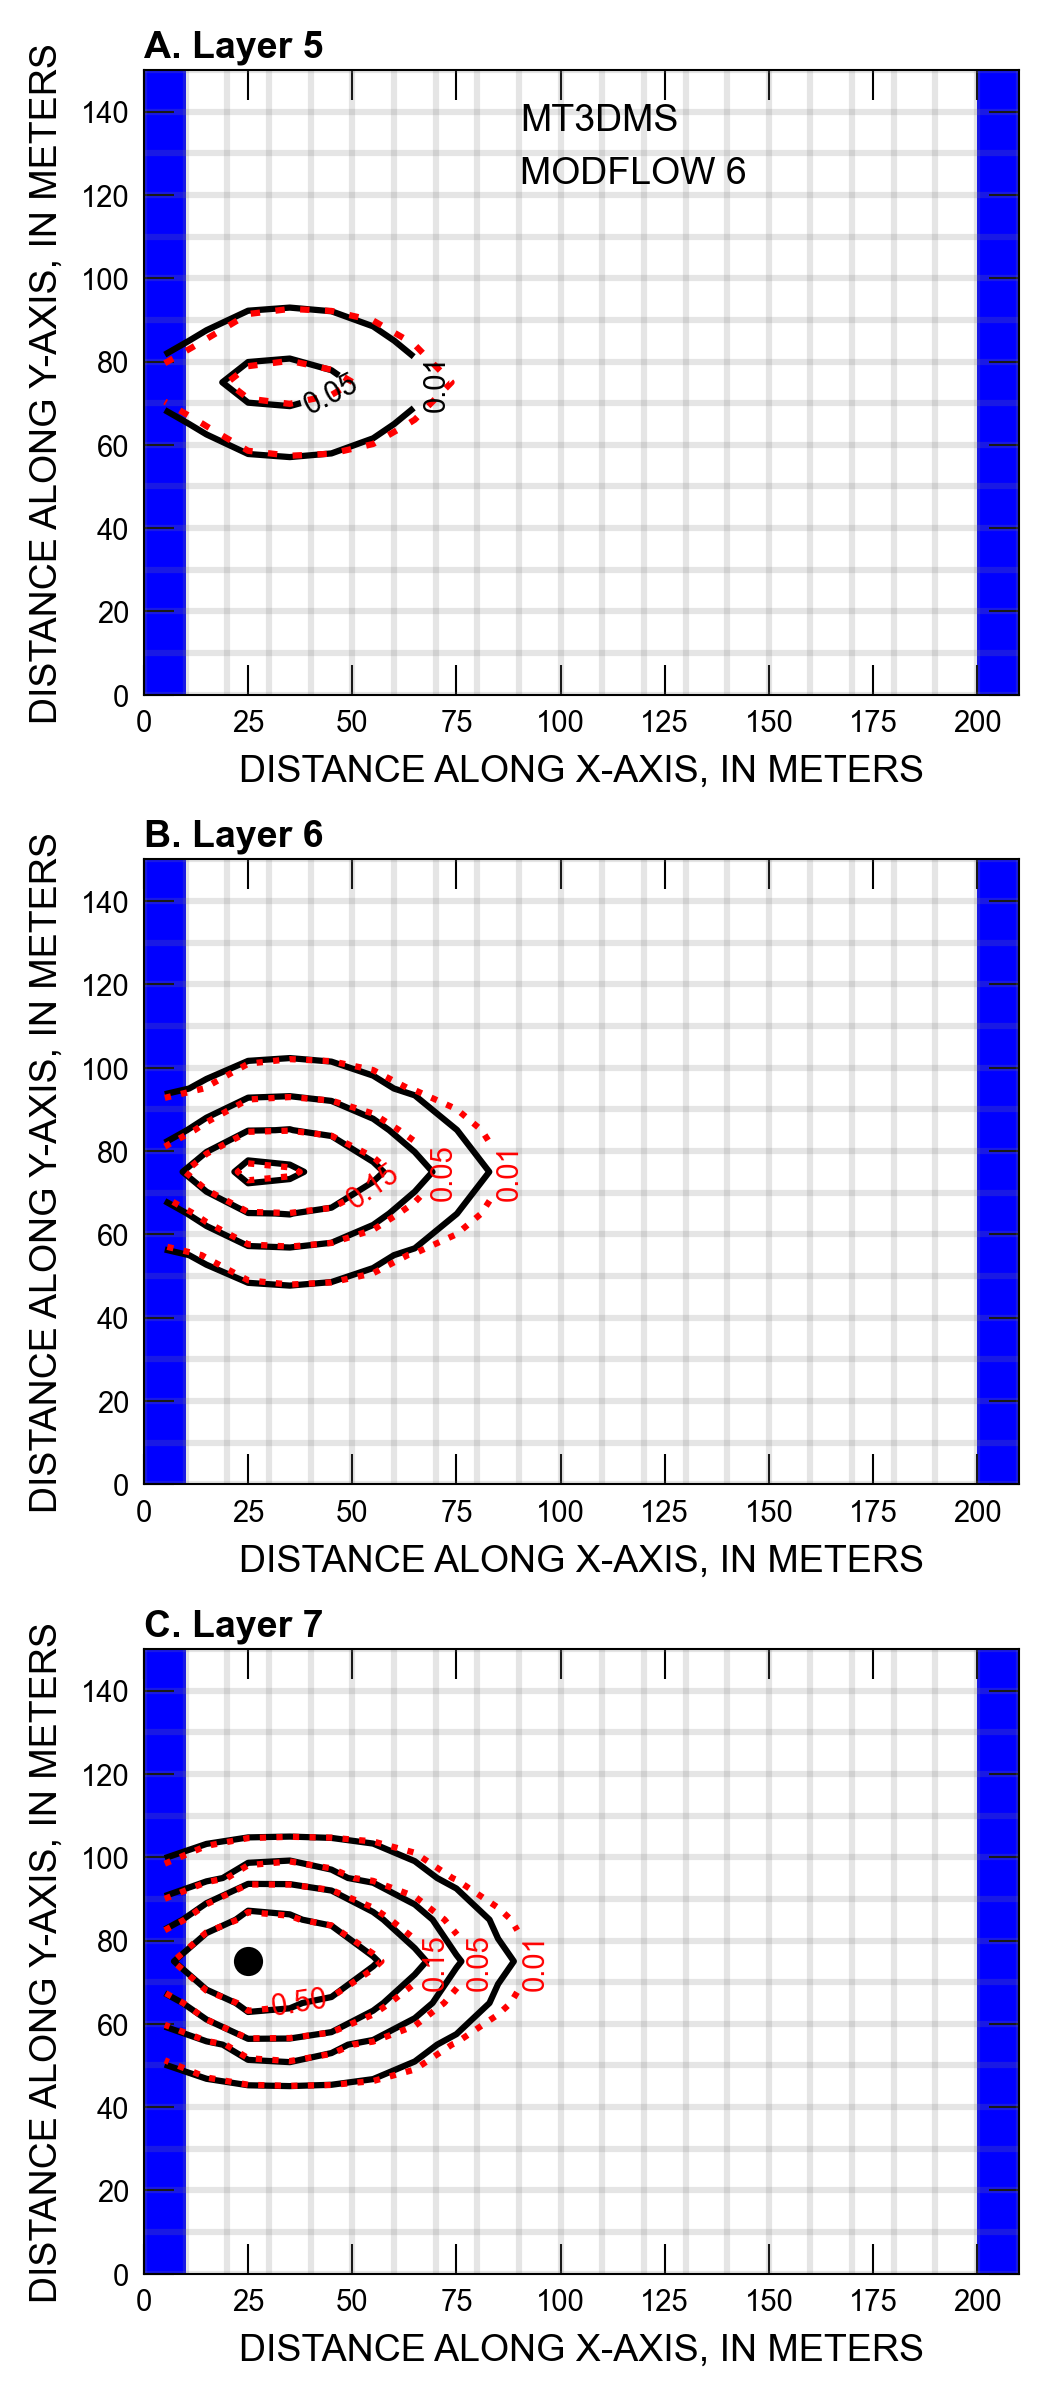

In [6]:
scenario(0)